<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Discovering-DNA-motifs-using-convolutional-neural-networks" data-toc-modified-id="Discovering-DNA-motifs-using-convolutional-neural-networks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Discovering DNA motifs using convolutional neural networks</a></span></li><li><span><a href="#EWSR1-motif" data-toc-modified-id="EWSR1-motif-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EWSR1 motif</a></span></li><li><span><a href="#Generating-sequences" data-toc-modified-id="Generating-sequences-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generating sequences</a></span></li><li><span><a href="#Labeling-the-sequences" data-toc-modified-id="Labeling-the-sequences-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Labeling the sequences</a></span></li><li><span><a href="#Balancing-classes" data-toc-modified-id="Balancing-classes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Balancing classes</a></span></li><li><span><a href="#Building-a-mixture-network-model" data-toc-modified-id="Building-a-mixture-network-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Building a mixture-network model</a></span></li><li><span><a href="#Metrics-to-assess-bias-and-variance-during-training" data-toc-modified-id="Metrics-to-assess-bias-and-variance-during-training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Metrics to assess bias and variance during training</a></span></li><li><span><a href="#Training-the-network" data-toc-modified-id="Training-the-network-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Training the network</a></span></li><li><span><a href="#Comparing-predictions-with-truth" data-toc-modified-id="Comparing-predictions-with-truth-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Comparing predictions with truth</a></span></li><li><span><a href="#Performance-metric" data-toc-modified-id="Performance-metric-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Performance metric</a></span></li></ul></div>

## Discovering DNA motifs using convolutional neural networks

The goal is to train a convolutional neural network to predict whether a given input sequence contains a given motif. We will do this by generating synthetic training examples (sequences) that have been labeled according to whether they contain a given motif or not. The labeling will be a simulated per-base read-depth coverage observed at the center of the DNA sequence. The hope is that the trained network can be used to recover, somehow, the injected motif. 



## EWSR1 motif 

We will start with the following motif from [JASPAR](http://jaspar.genereg.net/cgi-bin/jaspar_db.pl?ID=MA0149.1&rm=present&collection=CORE):
![title](http://jaspar.genereg.net/static/logos/MA0149.1.BIG.png)

In [1]:
import numpy as np
motif = np.array([[   0,   2, 104, 104,   1,   2, 103, 102,   0,   0,  99, 105,   0,   0, 100, 102,   5,   3],
                  [   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   4,   0,   0,   2,   3,   0,   0,   3],
                  [ 105, 103,   1,   1, 104, 102,   2,   3, 104, 103,   2,   0, 105, 103,   0,   2,  97,  97],
                  [   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   2,   1,   3,   2]])


## Generating sequences

We wish to create a set of "positive" examples in which the motif is embedded. We can do this by drawing nucleotides at random with probabilities proportional to the frequency matrix, and then extending the sequence so generated upstream and downstream by drawing nucleotides at random with equal probability: 

In [2]:
sequence_length = 30

def build_positive_sequences(number_positive_examples_=5000):
    motif_plus_background = np.hstack([np.ones((4, (sequence_length-motif.shape[1])//2)), 
                                       motif,
                                       np.ones((4, (sequence_length-motif.shape[1])//2))])

    positive_examples = \
    np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                               size=number_positive_examples_, 
                               p=motif_plus_background[:,position]/float(np.sum(motif_plus_background[:,position]))) 
              for position in range(sequence_length)]).transpose()

    sequences_positive_ = []
    for positive_example in positive_examples: 
        sequences_positive_.append(''.join(positive_example))
        
    return sequences_positive_

number_positive_examples = 5000

sequences_positive = build_positive_sequences(number_positive_examples)

sequences_positive[:5]


['CGAACAGGAAGGAGGGAAGGAAGGTAGGAA',
 'ACGATGGGAAGGAAGGAAGGAAGGCCCATT',
 'CCGCGAGGAGGGAAGGAAGGAAAGAGCTAG',
 'AATTCCGGAAGGAAGGAAGGAAGGGCGGAT',
 'GTCGCCGGAAGGAAGGAAGGAAGGGGGAGA']

Now let's produce a set of "negative" examples (i.e., examples not containing the motif) by sampling nucleotides with equal frequency, regardless of their position in the sequence: 

In [3]:
def build_negative_sequences(number_negative_examples_=995000):
    negative_examples_ = \
    np.array([np.random.choice(['A', 'C', 'G', 'T'], 
                               size=number_negative_examples_, 
                               p=np.array([1,1,1,1])/4.0) 
              for position in range(sequence_length)]).transpose()

    sequences_negative_ = []
    for negative_example in negative_examples_: 
        sequences_negative_.append(''.join(negative_example))
        
    return sequences_negative_

number_negative_examples = 995000

sequences_negative = build_negative_sequences(number_negative_examples)

sequences_negative[:5]

['GCATAACATGTCGACTGGCCCGATGCGTTC',
 'CCGGATCCCGGACAGCGACAGCGTAAATGG',
 'CAGAAGAGTGTTTGGACAATATATGGCGAC',
 'CGGTAGCGGACTATCCAGTCCTTACTCTAA',
 'TGACTAGTACATAGTCTCGCTGGGTCCGGC']

## Labeling the sequences

We label these examples with simulated read depths drawn from a mixture distribution: 

\begin{equation} 
P(N=n|S=s) = \sum_{i=1}^m P(Z=z_i|S=s) \, P(N=n|S=s, Z=z_i).
\end{equation} 

where $S$ represents DNA sequence, $N$ represents read count, and $Z$ is a hidden random variable. 
We can write this more compactly as 

\begin{equation} 
p(n|s) = \sum_{i=1}^m \pi_i(s) \, \phi_i(n|s) .
\end{equation} 


We will assume that each component is Poisson distributed: 

\begin{equation} 
\phi_i(n|s) = \mbox{Poisson}(n|\, \lambda_i(s)).
\end{equation} 


In [4]:
def coefficient_vector(motif_): # \pi_i(s)
    if motif_:
        return np.array([0.1, 0.7, 0.1, 0.1])
    else: 
        return np.array([0, 0, 0, 1])

def rate_vector(motif_): # \lambda_i(s)
    if motif_: 
        return np.array([30, 40, 50, 60])
    else: 
        return np.array([0, 0, 0, 100])
    
def sample_rates(motif_, number_of_examples, rate_vector_): 
    components = np.random.choice(a=len(coefficient_vector(True)), size=number_of_examples, p=coefficient_vector(motif_))
    return np.array([rate_vector_(motif_)[component] for component in components])
        
def sample_from_mixture_distribution(motif_):    
    number_examples = number_positive_examples if motif_ else number_negative_examples
    rates = sample_rates(motif_, number_examples)
    # https://github.com/numpy/numpy/issues/7843 ...
    return np.random.poisson(lam=rates[:, np.newaxis], size=(len(rates), 1)) 

noisy_signals_positive = sample_from_mixture_distribution(motif_=True)
noisy_signals_negative = sample_from_mixture_distribution(motif_=False)

## Balancing classes



The data is currently highly imbalanced: examples from the negative class vastly outnumber those from the positive class:

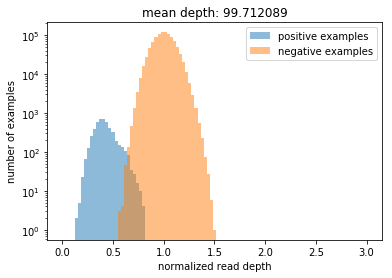

In [5]:
observed_mean_depth = np.mean(np.concatenate((noisy_signals_positive, noisy_signals_negative)))

import matplotlib.pyplot as plt
%matplotlib inline 

bins = np.linspace(0, 3, 100)
plt.hist(noisy_signals_positive/observed_mean_depth, bins, alpha=0.5, label='positive examples')
plt.hist(noisy_signals_negative/observed_mean_depth, bins, alpha=0.5, label='negative examples')
plt.legend(loc='upper right')
plt.ylabel('number of examples')
plt.xlabel('normalized read depth')
plt.yscale('log')
_ = plt.title('mean depth: ' + str(observed_mean_depth))

This imbalance is a problem because we will soon be maximizing the likelihood of getting ALL the data under a given model and the imbalance means that the likelihood will be largely determined by the ability of the model to predict the majority class, whereas we want the model to discriminate between the classes.

One way to counteract the tendancy to fit data from the majority class at the expense of poorly fitting data from the minority class is to attempt to balance the classes by evening out the distribution of read depths: 

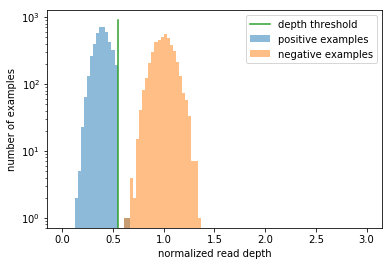

In [6]:
import pandas as pd
from collections import OrderedDict 

# https://stackoverflow.com/questions/45548426/store-numpy-array-in-cells-of-a-pandas-dataframe
data_original = pd.DataFrame(OrderedDict([
    ('sequence', np.concatenate((sequences_positive, sequences_negative))),    
    ('observed_depth', list(noisy_signals_positive[:,0]) + list(noisy_signals_negative[:,0])),
    ('class', [1]*len(noisy_signals_positive) + [0]*len(noisy_signals_negative)),
    ('true_coefficients',[np.array_str(coefficient_vector(motif_=True))]*len(noisy_signals_positive) + [np.array_str(coefficient_vector(motif_=False))]*len(noisy_signals_negative)),
    ('true_rates',[np.array_str(rate_vector(motif_=True))]*len(noisy_signals_positive) + [np.array_str(rate_vector(motif_=False))]*len(noisy_signals_negative))
]))

# add fake genomic positions
data_original['position'] = np.random.permutation(len(data_original))

def balance__two_classes(df, threshold_depth):
    low_depth_class = df['observed_depth'] < threshold_depth*observed_mean_depth
    df_low_depth = df[low_depth_class]
    df_high_depth = df[~low_depth_class].sample(n=len(df_low_depth))
    df_balanced = pd.concat([df_low_depth, df_high_depth])

    positive_class = df_balanced['class'] == 1
    df_balanced_positive = df_balanced[positive_class]
    df_balanced_negative = df_balanced[~positive_class]
    hist_positive = plt.hist(df_balanced_positive['observed_depth']/observed_mean_depth, bins, alpha=0.5, label='positive examples')
    hist_negative = plt.hist(df_balanced_negative['observed_depth']/observed_mean_depth, bins, alpha=0.5, label='negative examples')
    max_counts = max(hist_positive[0] + hist_negative[0])
    plt.plot([threshold_depth, threshold_depth], [0, 1.25*max_counts], label='depth threshold')
    plt.legend(loc='upper right')
    plt.ylabel('number of examples')
    plt.xlabel('normalized read depth')
    plt.yscale('log')

    return df_balanced

data = balance__two_classes(data_original, threshold_depth=0.55)

Next, split the data into train, dev and test sets. First, though, we must shuffle the data so that the distribution of positive and negative classes is the same in the three data sets (recall that the positive examples mainly appear at the head of the list of examples, and the negative examples mainly at the tail). 

In [7]:
# shuffle data
data = data.sample(frac=1) 

# split data
test_dev_sets_size = min(1000, int(0.1*len(data)))
# make copies to avoid settingwithcopywarning: https://www.dataquest.io/blog/settingwithcopywarning
data_test = data[:test_dev_sets_size].copy()
data_dev = data[test_dev_sets_size:2*test_dev_sets_size].copy()
data_train = data[2*test_dev_sets_size:].copy()

Since the sequences are categorical data, we must encode them as numbers before passing them into a function that maps them to read depths. We use "one-hot encoding", creating a tensor with dimensions `(number_examples, sequence_length, number_channels)` where `number_channels = 4`: 

In [8]:
from load_preprocess_data import _preprocess_conv1d
X_test, y_test = _preprocess_conv1d(data_test)
X_dev, y_dev = _preprocess_conv1d(data_dev)
X_train, y_train = _preprocess_conv1d(data_train)

## Building a mixture-network model
Following [Bishop](http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf), we create a neural network that, when given a single DNA sequence, outputs a mixture of Poisson distributions: 

In [9]:
from tensorflow import enable_eager_execution
enable_eager_execution()

from tensorflow.keras.backend import clear_session

import tensorflow as tf
import tensorflow_probability as tfp 

def build_baseline_model():
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    conv1d = tfkl.Conv1D(
        filters=1, 
        kernel_size=motif.shape[1], 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)

    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    dropout = tfkl.Dropout(rate=0.25)(conv1d)

    flatten = tfkl.Flatten()(dropout)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters)(flatten)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    tfk = tf.keras
    baseline_model_ = tfk.Model(inputs=inputs, outputs=outputs)

    baseline_model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=0.02),
        loss=lambda y, d: -d.log_prob(y))

    print('baseline_model.inputs', baseline_model_.inputs)
    print('baseline_model.outputs', baseline_model_.outputs)
    baseline_model_.summary()
    
    return baseline_model_
    
baseline_model = build_baseline_model()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.random.categorical instead.
baseline_model.inputs [<tf.Tensor 'input_1:0' shape=(?, 30, 4) dtype=float32>]
baseline_model.outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)       

## Metrics to assess bias and variance during training

In [10]:
from tensorflow.keras.callbacks import Callback
tfd = tfp.distributions

# custom keras callback to record the losses in a consistent way
# (keras metrics may not compute train and dev losses consistently: 
# https://stackoverflow.com/questions/49359489/how-are-metrics-computed-in-keras)
class CustomHistory(Callback):
    def __init__(self, data_train_, data_dev_, data_test_):
        self.data_train_ = data_train_
        self.data_dev_ = data_dev_
        self.data_test_ = data_test_
        
    # loss WITHOUT L1 or L2 regularization,
    # which is appropriate for assessing the extent to which the model suffers from bias and variance
    def loss(self, data_):
        X, y = _preprocess_conv1d(data_)
        # invoking "model(X)" guarantees that loss is computed without dropout 
        training_joint_distribution = tfd.Independent(self.model(X), reinterpreted_batch_ndims=1)
        training_log_likelihood = training_joint_distribution.log_prob(y)
        return -training_log_likelihood.numpy()/len(X)

    def on_train_begin(self, logs={}):
        self.epochs = []
        self.train_losses = []
        self.dev_losses = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.train_losses.append(self.loss(self.data_train_))
        self.dev_losses.append(self.loss(self.data_dev_))
        self.test_losses.append(self.loss(self.data_test_))
  




## Training the network

In [11]:
baseline_custom_history = CustomHistory()
batch_size = 100

baseline_standard_history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),
    batch_size=batch_size,
    epochs=60,
    steps_per_epoch=len(X_train)//batch_size,
    callbacks=[baseline_custom_history])

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
70/70 [==============================] - 2s 28ms/step - loss: 23.4679 - val_loss: 5.4471
Epoch 2/60
70/70 [==============================] - 2s 24ms/step - loss: 7.7910 - val_loss: 4.5185
Epoch 3/60
70/70 [==============================] - 2s 25ms/step - loss: 6.8448 - val_loss: 4.2765
Epoch 4/60
70/70 [==============================] - 2s 26ms/step - loss: 6.0491 - val_loss: 4.3075
Epoch 5/60
70/70 [==============================] - 2s 26ms/step - loss: 5.5026 - val_loss: 4.4658
Epoch 6/60
70/70 [==============================] - 2s 25ms/step - loss: 4.9862 - val_loss: 5.0769
Epoch 7/60
70/70 [==============================] - 2s 25ms/step - loss: 4.5415 - val_loss: 6.0551
Epoch 8/60
70/70 [==============================] - 2s 25ms/step - loss: 4.3848 - val_loss: 6.0609
Epoch 9/60
70/70 [==============================] - 2s 25ms/step - loss: 4.2905 - val_loss: 6.2124
Epoch 10/60
70/70 [==============================] - 2s 25ms

Side Note: Keras shuffles the training data at each epoch: [see here](https://keras.io/getting-started/faq/#is-the-data-shuffled-during-training).

Let's monitor the network's performance during the training process: 

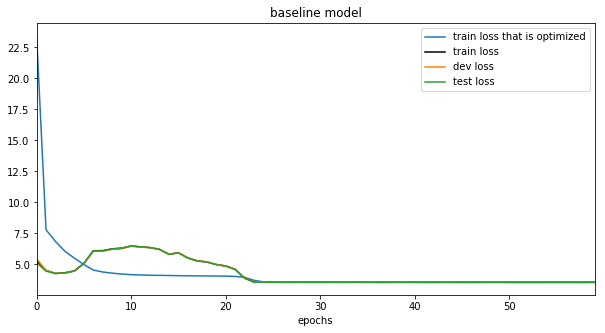

In [12]:
def plot_history(models):
    plt.figure(figsize=(10,5))    
    for name, standard_history, custom_history in models:
        plt.title(name)
        plt.plot(standard_history.epoch, 
                 standard_history.history['loss'], 
                 label='train loss that is optimized')
        plt.plot(custom_history.epochs, 
                 custom_history.train_losses, 
                 label='train loss', 
                 color='black')
        plt.plot(custom_history.epochs, 
                 custom_history.dev_losses, 
                 label='dev loss')
        plt.plot(custom_history.epochs, 
                 custom_history.test_losses, 
                 label='test loss')
        plt.xlabel('epochs')
        plt.legend()
        plt.xlim([0, max(standard_history.epoch)])        
        
plot_history([('baseline model', baseline_standard_history, baseline_custom_history)])

## Comparing predictions with truth

There seems to be some overlap between the predicted values of the coefficients and rates of the Poisson components and their true values:

In [13]:
def compute_coefficients_rates(df, model_): 
    X_, _ = _preprocess_conv1d(df)    
    df['predicted_coefficients'] = list(model_(X_).mixture_distribution.probs.numpy())
    df['predicted_rates'] = list(model_(X_).components_distribution.distribution.rate.numpy().squeeze())

pd.set_option('max_colwidth', 100)
compute_coefficients_rates(data_train, baseline_model)
data_train[data_train['class'] == 0].head()


,sequence,observed_depth,class,true_coefficients,true_rates,position,predicted_coefficients,predicted_rates
718123,CATAGGGTGTACCCCCGCCTTGGGGCCCAG,117,0,[0 0 0 1],[ 0 0 0 100],883221,"[1.0, 3.3971375e-18, 1.019695e-17, 1.223805e-16, 7.4213006e-19]","[97.76305, 428.0881, 142.92259, 97.046524, 105.98501]"
93857,AAGCACATCAAGCGAGACCTCCCCATGGAA,93,0,[0 0 0 1],[ 0 0 0 100],277885,"[1.0, 1.0638364e-12, 1.9157805e-12, 1.4676127e-10, 2.1488006e-11]","[98.541466, 166.9246, 92.02667, 50.831387, 81.916916]"
905732,TATCATAATAGAGTTGCTTGTAGGACCCGG,94,0,[0 0 0 1],[ 0 0 0 100],215530,"[1.0, 2.051009e-12, 5.6721416e-12, 8.275434e-10, 1.04719844e-10]","[98.353226, 142.84076, 122.22019, 60.1627, 79.2741]"
116392,GACCGAGACTTCTACGAACTACAACCGCTC,100,0,[0 0 0 1],[ 0 0 0 100],602996,"[1.0, 4.316329e-13, 1.0533553e-12, 6.6390304e-10, 2.6630276e-11]","[98.31829, 243.56393, 264.9672, 74.922264, 75.01485]"
779453,GGTAAATCAGCAAGACTTGTAAGATCATTC,96,0,[0 0 0 1],[ 0 0 0 100],920220,"[1.0, 3.529727e-12, 1.1425632e-11, 1.5116805e-10, 1.8057653e-11]","[98.0066, 121.34473, 155.15048, 63.639206, 72.77716]"


In [14]:
data_train[data_train['class'] == 1].head()

,sequence,observed_depth,class,true_coefficients,true_rates,position,predicted_coefficients,predicted_rates
3746,TTGGGTGGAAGGGAGGAAGCAAGGGCCCGC,29,1,[0.1 0.7 0.1 0.1],[30 40 50 60],793700,"[0.011241077, 8.098598e-05, 7.398074e-05, 0.1684871, 0.8201169]","[99.48535, 29.96221, 48.00642, 29.678463, 39.83263]"
4556,ACACGGGGAAGGAAGGAAGGAAGGCCGGAT,46,1,[0.1 0.7 0.1 0.1],[30 40 50 60],612726,"[0.00052883575, 9.874803e-06, 1.1664316e-05, 0.09761047, 0.90183914]","[99.495834, 26.890713, 58.919094, 29.524208, 40.683456]"
3716,ACCCTTGGAAGGAAGGAAGGAAGGCAGCAC,33,1,[0.1 0.7 0.1 0.1],[30 40 50 60],255207,"[0.0004197251, 5.2167993e-06, 6.8406393e-06, 0.10464722, 0.894921]","[99.46742, 29.863733, 91.75493, 29.699457, 40.65547]"
616,GACGATGGAAGGAAGGAAGGAAGGCGTGTA,37,1,[0.1 0.7 0.1 0.1],[30 40 50 60],715752,"[0.00046379783, 6.7695896e-06, 8.757384e-06, 0.10126061, 0.89826006]","[99.46803, 28.361496, 76.80022, 29.582012, 40.611084]"
1873,GGTCTGGGAAGGAAGGAAGGAAGGACAGCT,44,1,[0.1 0.7 0.1 0.1],[30 40 50 60],495486,"[0.0007018081, 8.925884e-06, 1.1583495e-05, 0.09920323, 0.9000745]","[99.42787, 27.945755, 75.03703, 29.160036, 40.708878]"


Let's compare the predicted mean depth with the true mean depth: 

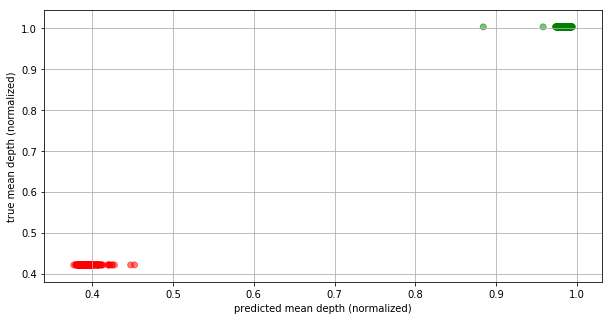

In [15]:
data_train['predicted_mean'] = list(baseline_model(X_train).mean().numpy().squeeze())

def compute_true_mean(motif_, rate_vector_=rate_vector): 
    return np.dot(coefficient_vector(motif_), rate_vector_(motif_))

data_train.loc[data_train['class'] == 0, 'true_mean'] = compute_true_mean(motif_=False)
data_train.loc[data_train['class'] == 1, 'true_mean'] = compute_true_mean(motif_=True)

figsize=(10,5)

def colors(df): 
    colors = []
    for class_membership in df['class']: 
        colors.append('red' if class_membership else 'green')
    return colors
 
def evaluate_means(df):
    plt.figure(figsize=figsize)    
    plt.scatter(df['predicted_mean']/observed_mean_depth, 
                df['true_mean']/observed_mean_depth, 
                label=None,
                c=colors(df),
                alpha=0.5)
    plt.xlabel('predicted mean depth (normalized)')
    plt.ylabel('true mean depth (normalized)')
    plt.grid()
    
evaluate_means(data_train)

Compare samples from the predicted distributions (there is one distribution for each sample) with samples from the true distributions (there is one distribution for each class): 

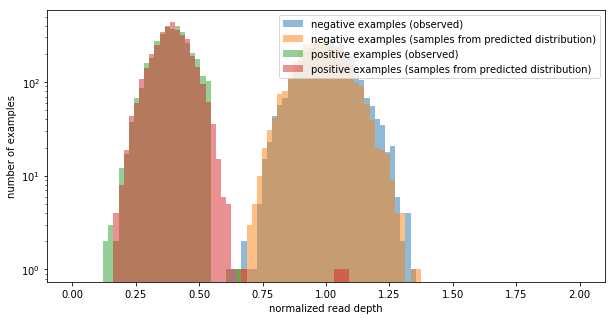

In [16]:
data_train['sample_from_predicted_distribution'] = baseline_model(X_train).sample().numpy().squeeze()

def evaluate_distributions(df):
    bins = np.linspace(0, 2, 100)
    df_negative = df[df['class'] == 0]
    df_positive = df[df['class'] == 1]
    plt.figure(figsize=figsize)    
    plt.hist(df_negative['observed_depth']/observed_mean_depth, bins, alpha=0.5, label='negative examples (observed)')
    plt.hist(df_negative['sample_from_predicted_distribution']/observed_mean_depth, bins, alpha=0.5, label='negative examples (samples from predicted distribution)')
    plt.hist(df_positive['observed_depth']/observed_mean_depth, bins, alpha=0.5, label='positive examples (observed)')
    plt.hist(df_positive['sample_from_predicted_distribution']/observed_mean_depth, bins, alpha=0.5, label='positive examples (samples from predicted distribution)')
    plt.legend(loc='upper right')
    plt.ylabel('number of examples')
    plt.xlabel('normalized read depth')
    plt.yscale('log')
    
evaluate_distributions(data_train)

## Performance metric

Suppose the purpose of predicting read depth is to "correct" it. Concretely, letting $D$ represent depth, 
we wish to compute a corrected depth, 

\begin{equation} 
D_{corrected} = \frac{D_{observed}}{D_{predicted}},
\end{equation}

that lies outside some interval $I$ (centered on 1) less frequently than the corresponding uncorrected value, 

\begin{equation} 
D_{uncorrected} = \frac{D_{observed}}{\langle D_{observed} \rangle}.
\end{equation} 

One way to quantify this effect is: 

\begin{equation} 
\mbox{performance metric} = \frac{P\left[ D_{corrected} \in I \right]}
{P\left[ D_{uncorrected} \in I \right]}.
\end{equation}

Why might this performance metric be useful? Because values greater than unity might correspond to a reduction in the number of false-positive structural variant calls (deletions and duplications) produced by algorithms such as CNVnator as a result of feeding them corrected depths instead of uncorrected depths.

Let's compare corrected and uncorrected depths as a function of genomic coordinate:

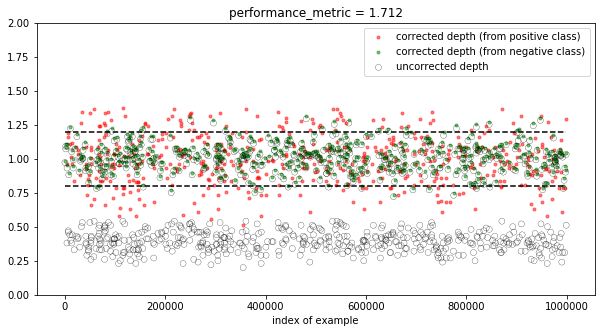

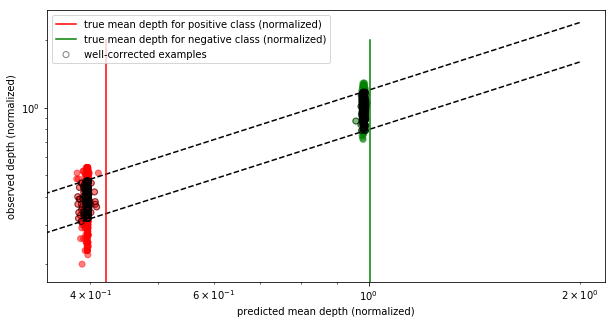

In [17]:
normalized_lower_depth_threshold, normalized_upper_depth_threshold = 0.8, 1.2

def performance_metric(df):
    cond_lower = df['corrected_depth'].values > normalized_lower_depth_threshold
    cond_upper = df['corrected_depth'].values < normalized_upper_depth_threshold
    prob_corrected = np.sum(cond_lower & cond_upper)/float(len(df))
    cond_lower = df['observed_depth'].values > normalized_lower_depth_threshold*observed_mean_depth
    cond_upper = df['observed_depth'].values < normalized_upper_depth_threshold*observed_mean_depth
    prob_observed = np.sum(cond_lower & cond_upper)/float(len(df))
    return prob_corrected/prob_observed

def correct(df, model):
    number_examples_ = 1000
    if len(df) > number_examples_: 
        df = df.sample(number_examples_).copy()        
    X, _ = _preprocess_conv1d(df)
    # pd.options.mode.chained_assignment = None  # default='warn'
    df['predicted_mean'] = list(model(X).mean().numpy().squeeze())
    df['corrected_depth'] = df['observed_depth']/df['predicted_mean']
    return df
    
def evaluate_performance(df, model, rate_vector_=rate_vector):
    df = correct(df, model)
    
    figsize=(10,5)
    normalized_max_depth = 2

    df_well_corrected = df[
        (df['corrected_depth'] > normalized_lower_depth_threshold) 
        &
        (df['corrected_depth'] < normalized_upper_depth_threshold)         
    ]

    plt.figure(figsize=figsize)
    plt.scatter(df[df['class'] == 1]['position'], 
                df[df['class'] == 1]['corrected_depth'].values, 
                marker='.',
                label='corrected depth (from positive class)',
                c='red',
                alpha=0.5)
    plt.scatter(df[df['class'] == 0]['position'], 
                df[df['class'] == 0]['corrected_depth'].values, 
                marker='.',
                label='corrected depth (from negative class)',
                c='green',
                alpha=0.5)
    plt.scatter(df['position'], 
                df['observed_depth'].values/observed_mean_depth,
                marker='o', facecolors='none', edgecolors='black', linewidth=0.25,
                label='uncorrected depth')
    plt.plot([0, max(df['position'])], [normalized_lower_depth_threshold, normalized_lower_depth_threshold], '--k')
    plt.plot([0, max(df['position'])], [normalized_upper_depth_threshold, normalized_upper_depth_threshold], '--k')
    plt.xlabel('index of example')
    _ = plt.legend(loc='upper right')
    plt.ylim([0, normalized_max_depth])
    plt.title('performance_metric = {:.3f}'.format(performance_metric(df)))

    plt.figure(figsize=figsize)    
    plt.scatter(df['predicted_mean']/observed_mean_depth, 
                df['observed_depth']/observed_mean_depth, 
                label=None,
                c=colors(df),
                alpha=0.5)
    plt.scatter(df_well_corrected['predicted_mean']/observed_mean_depth, 
                df_well_corrected['observed_depth']/observed_mean_depth, 
                label='well-corrected examples',
                marker='o', facecolors='none', edgecolors='k',
                alpha=0.5)
    plt.xlabel('predicted mean depth (normalized)')
    plt.ylabel('observed depth (normalized)')
    plt.plot([0, normalized_max_depth], 
             [0, (normalized_upper_depth_threshold)*normalized_max_depth], 
             '--k')
    plt.plot([0, normalized_max_depth], 
             [0, (normalized_lower_depth_threshold)*normalized_max_depth], 
             '--k')
    true_mean_positive = compute_true_mean(motif_=True, rate_vector_=rate_vector_)
    plt.plot([true_mean_positive/observed_mean_depth, true_mean_positive/observed_mean_depth], 
             [0, normalized_max_depth], 
             'red', label='true mean depth for positive class (normalized)')    
    true_mean_negative = compute_true_mean(motif_=False, rate_vector_=rate_vector_)
    plt.plot([true_mean_negative/observed_mean_depth, true_mean_negative/observed_mean_depth], 
             [0, normalized_max_depth], 
             'green', label='true mean depth for negative class (normalized)')    
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')

evaluate_performance(data_train, baseline_model)


The top graph shows that the algorithm has corrected the positive-class depths upwards. 

To improve the performance metric, we need to make more of the corrected depths sit inside the band bound by the dashed horizontal lines (top graph; interval chosen arbitrarily). The second graph quantifies how close the observed and predicted depths must be to one another to achieve this goal: examples need to lie in the band demarcated by the diagonal dashed lines. 

Clearly there is some bias in the model's predictions. The main problem, though, is the variance in the observed depths. Can this be reduced? The answer to that question depends upon whether that variance arises from Poisson fluctuations or variance in the hidden rate parameters. In the former case, increasing mean depth will reduce the variance in observed depths and improve denoising; in the latter case, it may not, as we demonstrate in the next notebook...

